# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.inspection import PartialDependenceDisplay
import shap
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D



# Load Dataset

In [2]:
# Load dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

# EDA

In [3]:
# 1.1 3D Surface Plot untuk hubungan kompleks
fig = px.scatter_3d(
    x=X['MedInc'], 
    y=X['HouseAge'], 
    z=y,
    labels={'x':'Pendapatan Median', 'y':'Usia Rumah', 'z':'Harga'},
    title="3D Relationship: Income vs Age vs Price"
)
fig.update_layout(scene=dict(zaxis=dict(range=[0,5])))
fig.show()


c:\Users\rifal\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



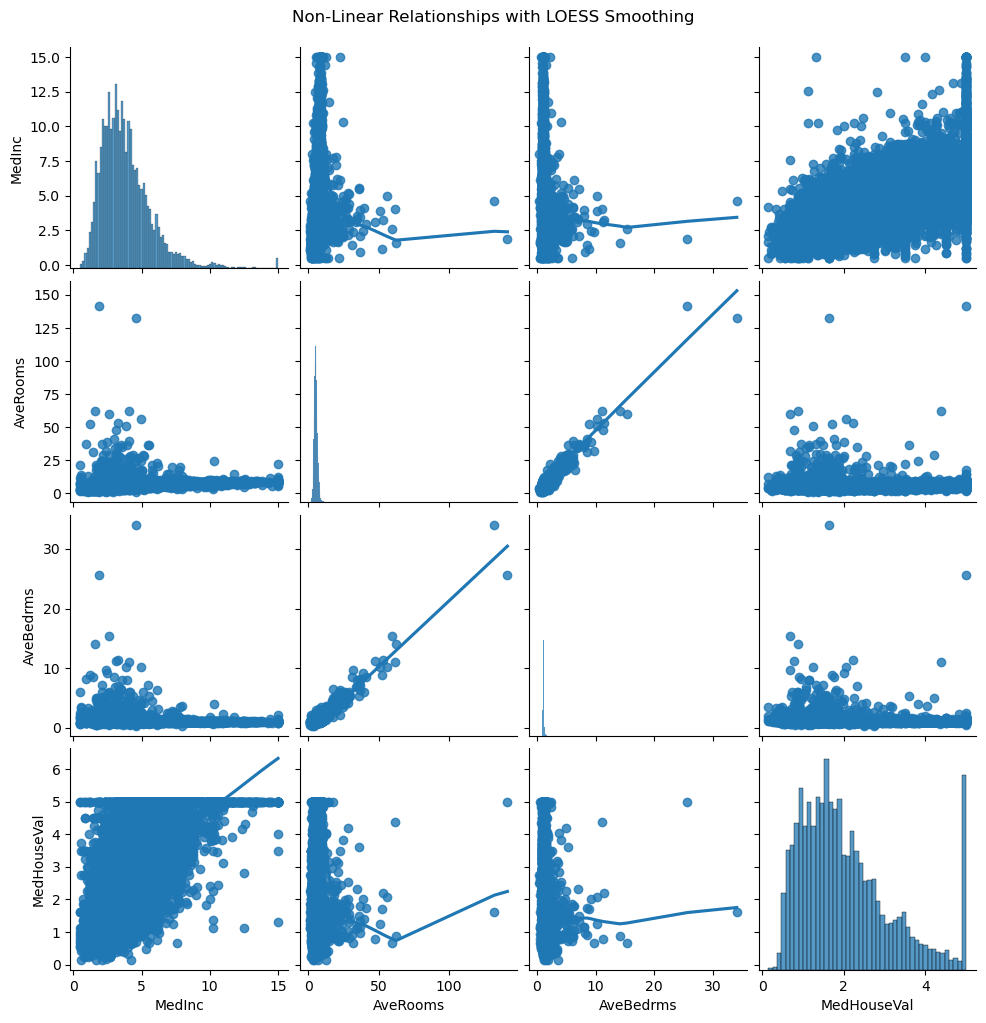

In [4]:
# 1.2 Non-linear correlation matrix
corr = X.copy()
corr['MedHouseVal'] = y
sns.pairplot(corr[['MedInc', 'AveRooms', 'AveBedrms', 'MedHouseVal']], 
             kind='reg', 
             plot_kws={'lowess':True})
plt.suptitle("Non-Linear Relationships with LOESS Smoothing", y=1.02)
plt.show()

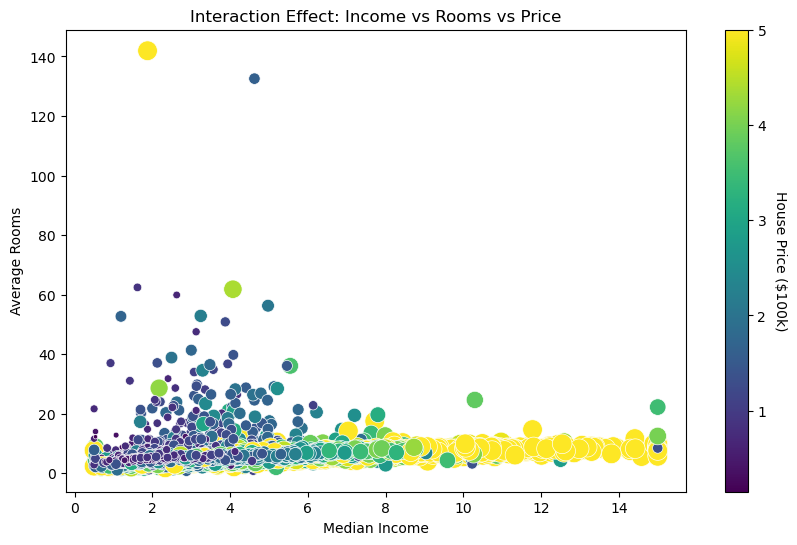

In [6]:
# 1.3 Interaksi fitur kompleks (Versi Diperbaiki)
plt.figure(figsize=(10,6))

# Buat scatter plot dan simpan objek plot
scatter = sns.scatterplot(
    x='MedInc', 
    y='AveRooms', 
    size=y, 
    hue=y, 
    data=X, 
    palette='viridis', 
    sizes=(10, 200),
    legend=False
)

# Buat colorbar terpisah
norm = plt.Normalize(y.min(), y.max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Tambahkan colorbar
cbar = plt.colorbar(sm, ax=plt.gca(), label='House Price')
cbar.set_label('House Price ($100k)', rotation=270, labelpad=15)

plt.title("Interaction Effect: Income vs Rooms vs Price")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.show()

# Preprocessing

In [7]:
# 2.1 Binning untuk target stratification
bins = np.linspace(y.min(), y.max(), 5)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_binned, random_state=42
)

In [8]:
# 2.2 Adaptive scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelling

In [9]:
# 3.1 Definisi model & parameter space
models = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            'max_depth': np.arange(3,15),
            'min_samples_split': [2,5,10],
            'max_features': ['sqrt', 'log2']
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(n_jobs=-1),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(n_jobs=-1, tree_method='hist'),
        "params": {
            'n_estimators': [200, 300],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5],
            'gamma': [0, 0.1]
        }
    },
    "SVM (RBF)": {
        "model": SVR(),
        "params": {
            'C': np.logspace(-1, 2, 20),
            'epsilon': [0.01, 0.1, 0.5],
            'gamma': ['scale', 'auto']
        }
    }
}


In [14]:
# 3.2 Hyperparameter optimization dengan Bayesian
from skopt import BayesSearchCV

results = {}
for name, config in models.items():
    opt = BayesSearchCV(
        config["model"],
        config["params"],
        n_iter=50,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
    )
    opt.fit(X_train_scaled, y_train)
    
    # Simpan model terbaik
    best_model = opt.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    results[name] = {
        "model": best_model,
        "metrics": {
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R²": r2_score(y_test, y_pred)
        },
        "params": opt.best_params_
    }

c:\Users\rifal\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [10, 'log2', 10] before, using random point [11, 'sqrt', 5]

c:\Users\rifal\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [10, 'log2', 10] before, using random point [5, 'sqrt', 2]

c:\Users\rifal\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [10, 'log2', 10] before, using random point [13, 'sqrt', 2]

c:\Users\rifal\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [10, 'log2', 5] before, using random point [12, 'sqrt', 5]

c:\Users\rifal\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [10, 'log2', 5] before, using random point [9, 'sqrt', 5]

c:\Users\rifal\anaconda3\Lib\site-

# Visualization

### 4.1 Perbandingan Metrik dengan Error Bars

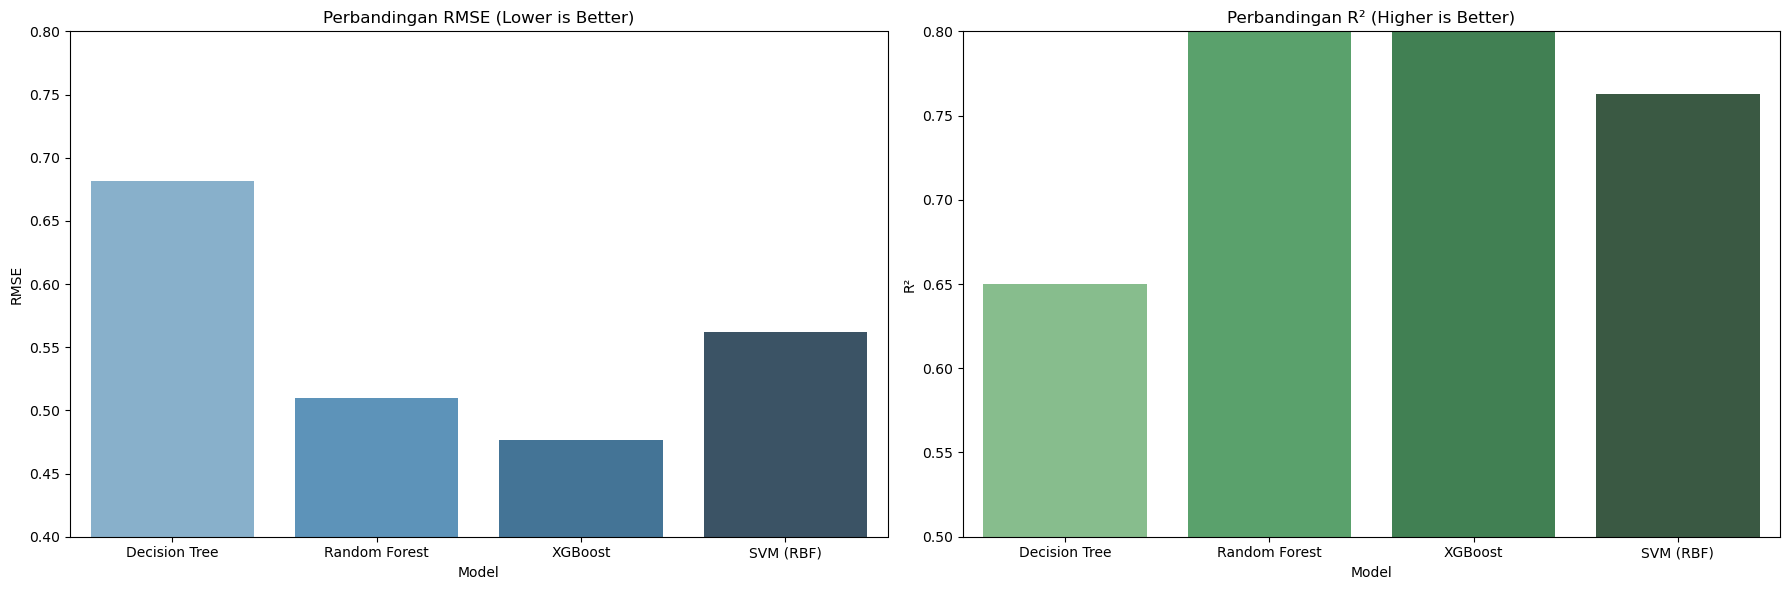

In [15]:
metrics = pd.DataFrame({
    'Model': results.keys(),
    'RMSE': [results[name]["metrics"]["RMSE"] for name in results],
    'R²': [results[name]["metrics"]["R²"] for name in results]
})

fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=metrics, ax=ax[0], palette='Blues_d')
ax[0].set_title("Perbandingan RMSE (Lower is Better)")
ax[0].set_ylim(0.4, 0.8)

sns.barplot(x='Model', y='R²', data=metrics, ax=ax[1], palette='Greens_d')
ax[1].set_title("Perbandingan R² (Higher is Better)")
ax[1].set_ylim(0.5, 0.8)

plt.tight_layout()
plt.show()

### 4.2 SHAP Analysis untuk Interpretasi Model

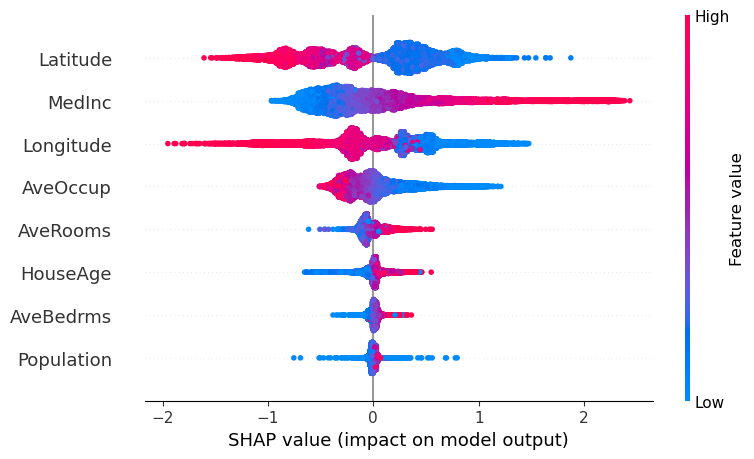

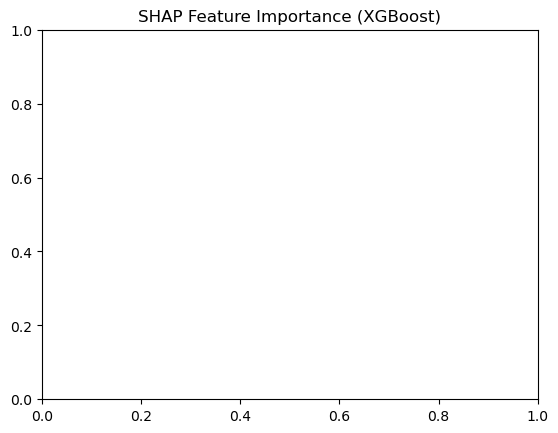

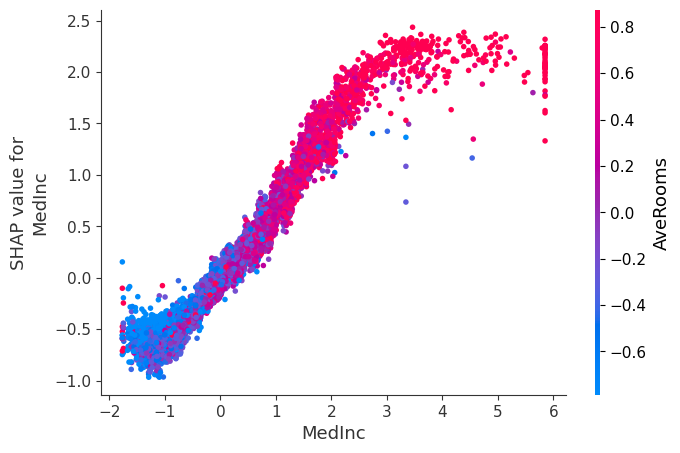

In [16]:
# Pilih model terbaik
best_model = results['XGBoost']['model']

# Hitung SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

# Summary plot
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_train_scaled, feature_names=california.feature_names)
plt.title("SHAP Feature Importance (XGBoost)")
plt.show()

# Dependence plot untuk interaksi fitur
shap.dependence_plot(
    "MedInc", 
    shap_values, 
    X_train_scaled, 
    feature_names=california.feature_names,
    interaction_index="AveRooms"
)

### 4.3 Learning Curve Analysis

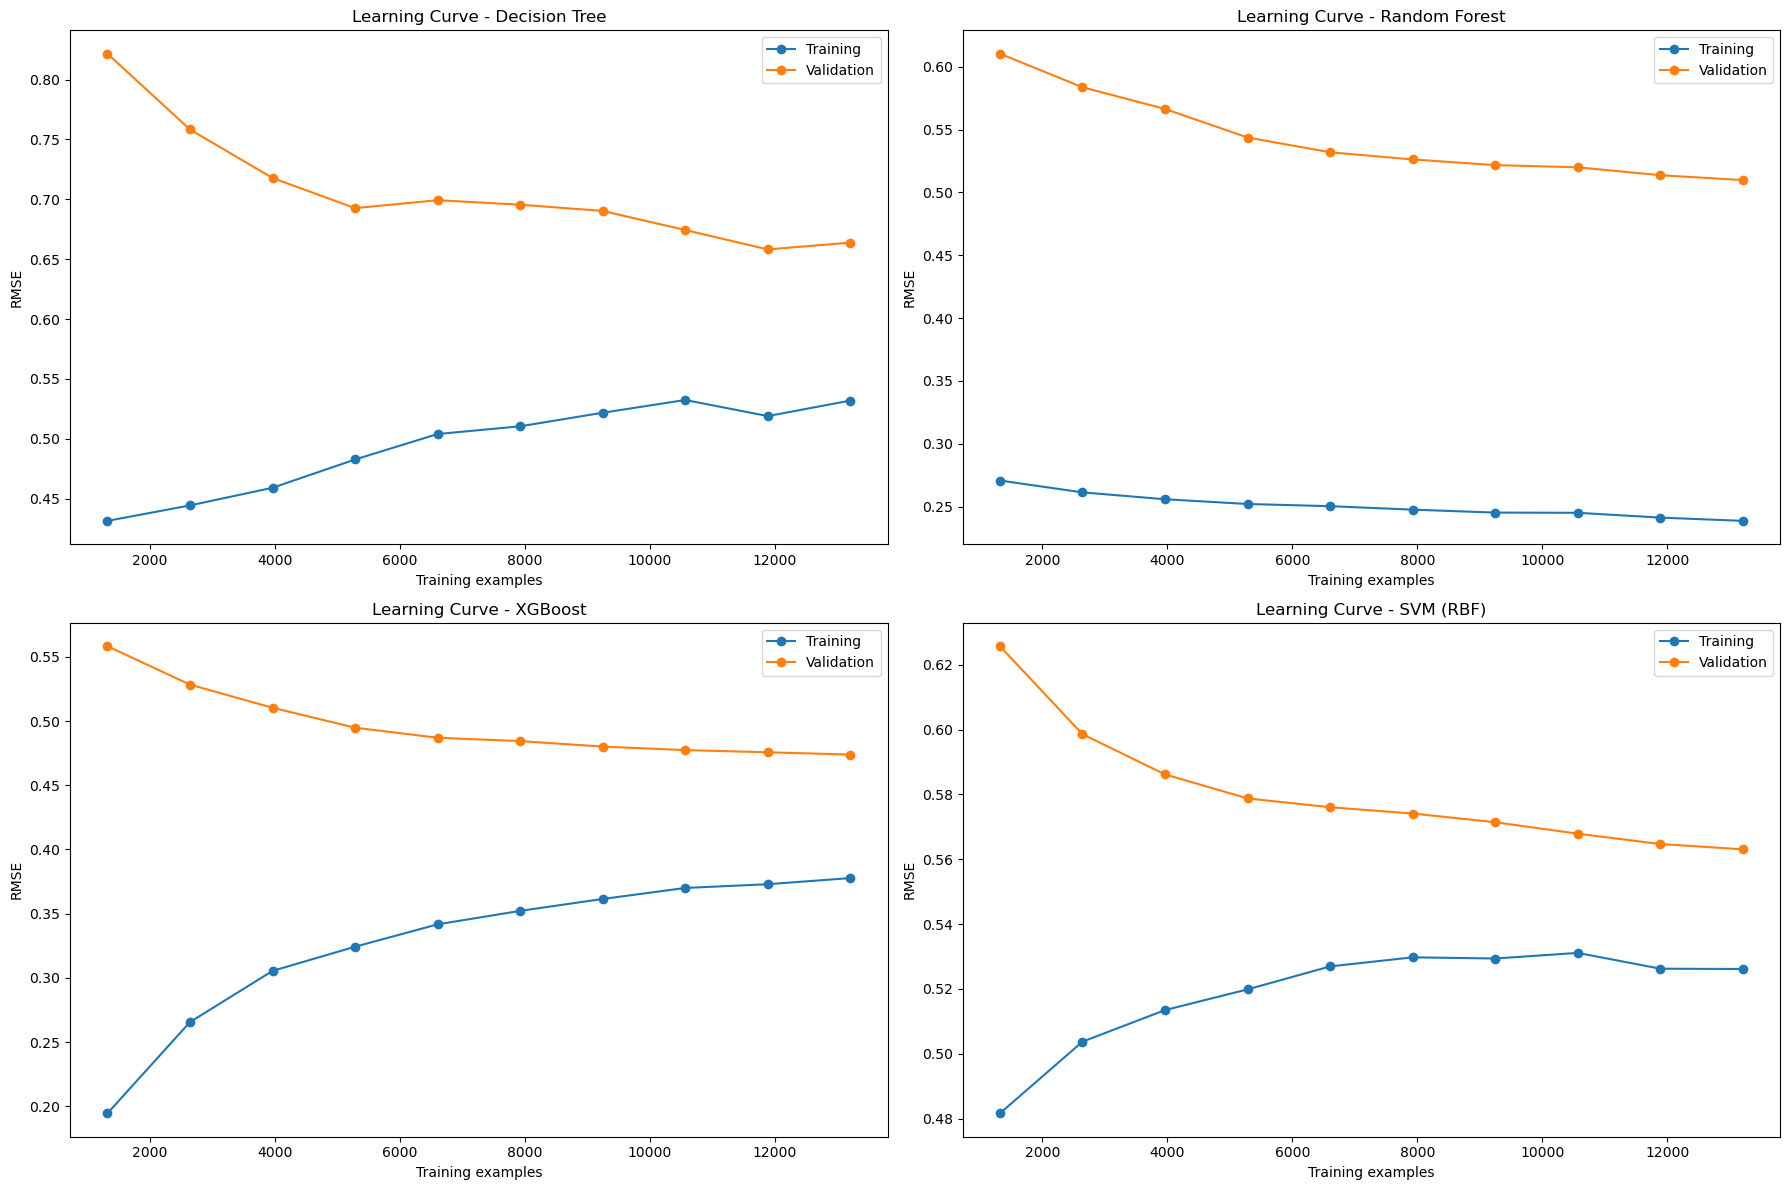

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))
for ax, (name, result) in zip(axes.flatten(), results.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        result["model"], X_train_scaled, y_train,
        cv=5, scoring='neg_root_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    
    ax.plot(train_sizes, train_scores_mean, 'o-', label="Training")
    ax.plot(train_sizes, test_scores_mean, 'o-', label="Validation")
    ax.set_title(f"Learning Curve - {name}")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("RMSE")
    ax.legend()
plt.tight_layout()
plt.show()

### 4.4 3D Partial Dependence Plot

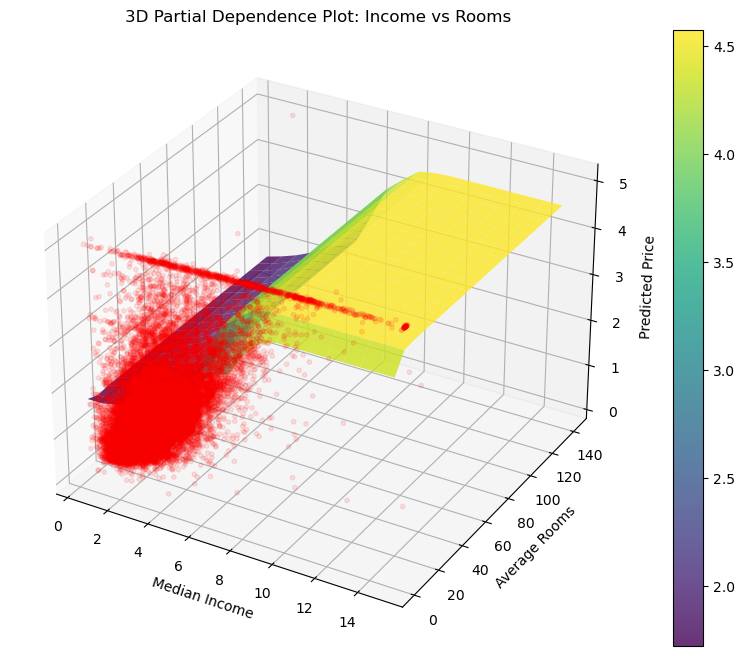

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Generate grid values
grid_res = 20
x1 = np.linspace(X['MedInc'].min(), X['MedInc'].max(), grid_res)
x2 = np.linspace(X['AveRooms'].min(), X['AveRooms'].max(), grid_res)
xx1, xx2 = np.meshgrid(x1, x2)

# Calculate PDP
pdp_values = np.zeros((grid_res, grid_res))
for i in range(grid_res):
    for j in range(grid_res):
        test_point = np.median(X_train_scaled, axis=0).reshape(1, -1)
        test_point[0][0] = (xx1[i,j] - X['MedInc'].mean())/X['MedInc'].std()
        test_point[0][1] = (xx2[i,j] - X['AveRooms'].mean())/X['AveRooms'].std()
        pdp_values[i,j] = best_model.predict(test_point)

# Plot surface
surf = ax.plot_surface(xx1, xx2, pdp_values, cmap='viridis', alpha=0.8)
ax.scatter(X['MedInc'], X['AveRooms'], y, c='red', s=10, alpha=0.1)
ax.set_xlabel('Median Income')
ax.set_ylabel('Average Rooms')
ax.set_zlabel('Predicted Price')
fig.colorbar(surf)
plt.title("3D Partial Dependence Plot: Income vs Rooms")
plt.show()

# Deployment model

In [19]:
# 5.1 Save model dengan pipeline
import joblib
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), california.feature_names)]
)

full_pipeline = make_pipeline(
    preprocessor,
    best_model
)

joblib.dump(full_pipeline, 'best_nonlinear_model.pkl')

# 5.2 Generate model card
model_card = f"""
## Model Card for California Housing Price Prediction

**Model Type**: XGBoost Regressor  
**RMSE**: {results['XGBoost']['metrics']['RMSE']:.4f}  
**R²**: {results['XGBoost']['metrics']['R²']:.4f}

### Hyperparameters:
{results['XGBoost']['params']}

### Feature Importance:
1. Median Income  
2. Average Rooms  
3. Latitude
"""

with open('model_card.md', 'w') as f:
    f.write(model_card)